In [1]:
'''from google.colab import drive
drive.mount('/content/gdrive')
'''

"from google.colab import drive\ndrive.mount('/content/gdrive')\n"

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from keras import optimizers
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [3]:
'''df = pd.read_csv(
  "gdrive/My Drive/Data Files/Google_Stock_Price_Train.csv", 
  parse_dates=True, 
  index_col=0
)
df.head()
'''

df = pd.read_csv(
  "https://raw.githubusercontent.com/D-GithubAccount/RNN_LSTM_GOOGL-StockPricePrediction/main/Google_Stock_Price_Train.csv", 
  parse_dates=True, 
  index_col=0
)
df.head()


,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
#url = 'gdrive/My Drive/Data Files/Google_Stock_Price_Test.csv'
url = 'https://raw.githubusercontent.com/D-GithubAccount/RNN_LSTM_GOOGL-StockPricePrediction/main/Google_Stock_Price_Test.csv'
test_data = pd.read_csv(url,parse_dates = True,index_col=0)
test_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,778.81,789.63,775.80,786.14,"1,657,300"
2017-01-04,788.36,791.34,783.16,786.90,"1,073,000"
2017-01-05,786.08,794.48,785.02,794.02,"1,335,200"
2017-01-06,795.26,807.90,792.20,806.15,"1,640,200"
2017-01-09,806.40,809.97,802.83,806.65,"1,272,400"


In [5]:
train_size = int(len(df))
test_size = int(len(test_data))
train, test = df.iloc[0:train_size], test_data.iloc[0:len(test_data)]
print(len(train), len(test))

1258 20


In [6]:
# Select features (columns) to be involved intro training and predictions
cols = list(train)[0:5]
print(cols)

['Open', 'High', 'Low', 'Close', 'Volume']


In [7]:
train = train.astype(str)

test = test.astype(str)

for i in cols:
    for j in range(0, len(train)):
        train[i][j] = train[i][j].replace(',', '')


for i in cols:
    for j in range(0, len(test)):
        test[i][j] = test[i][j].replace(',', '')
        

train = train.astype(float)
test= test.astype(float)

In [8]:
train_df = train

In [9]:
train_df['Timestep'] = np.arange(start = 1, stop = len(train_df) + 1 , step = 1 )

# Melt the data to have all the prices in a single column
training_melt_df = pd.melt(train_df[['Timestep','Open','High','Low','Close']],id_vars= ['Timestep'],value_vars=['Open','High','Low','Close'])
training_melt_df = training_melt_df.rename(columns = {'variable':'Stock price'})

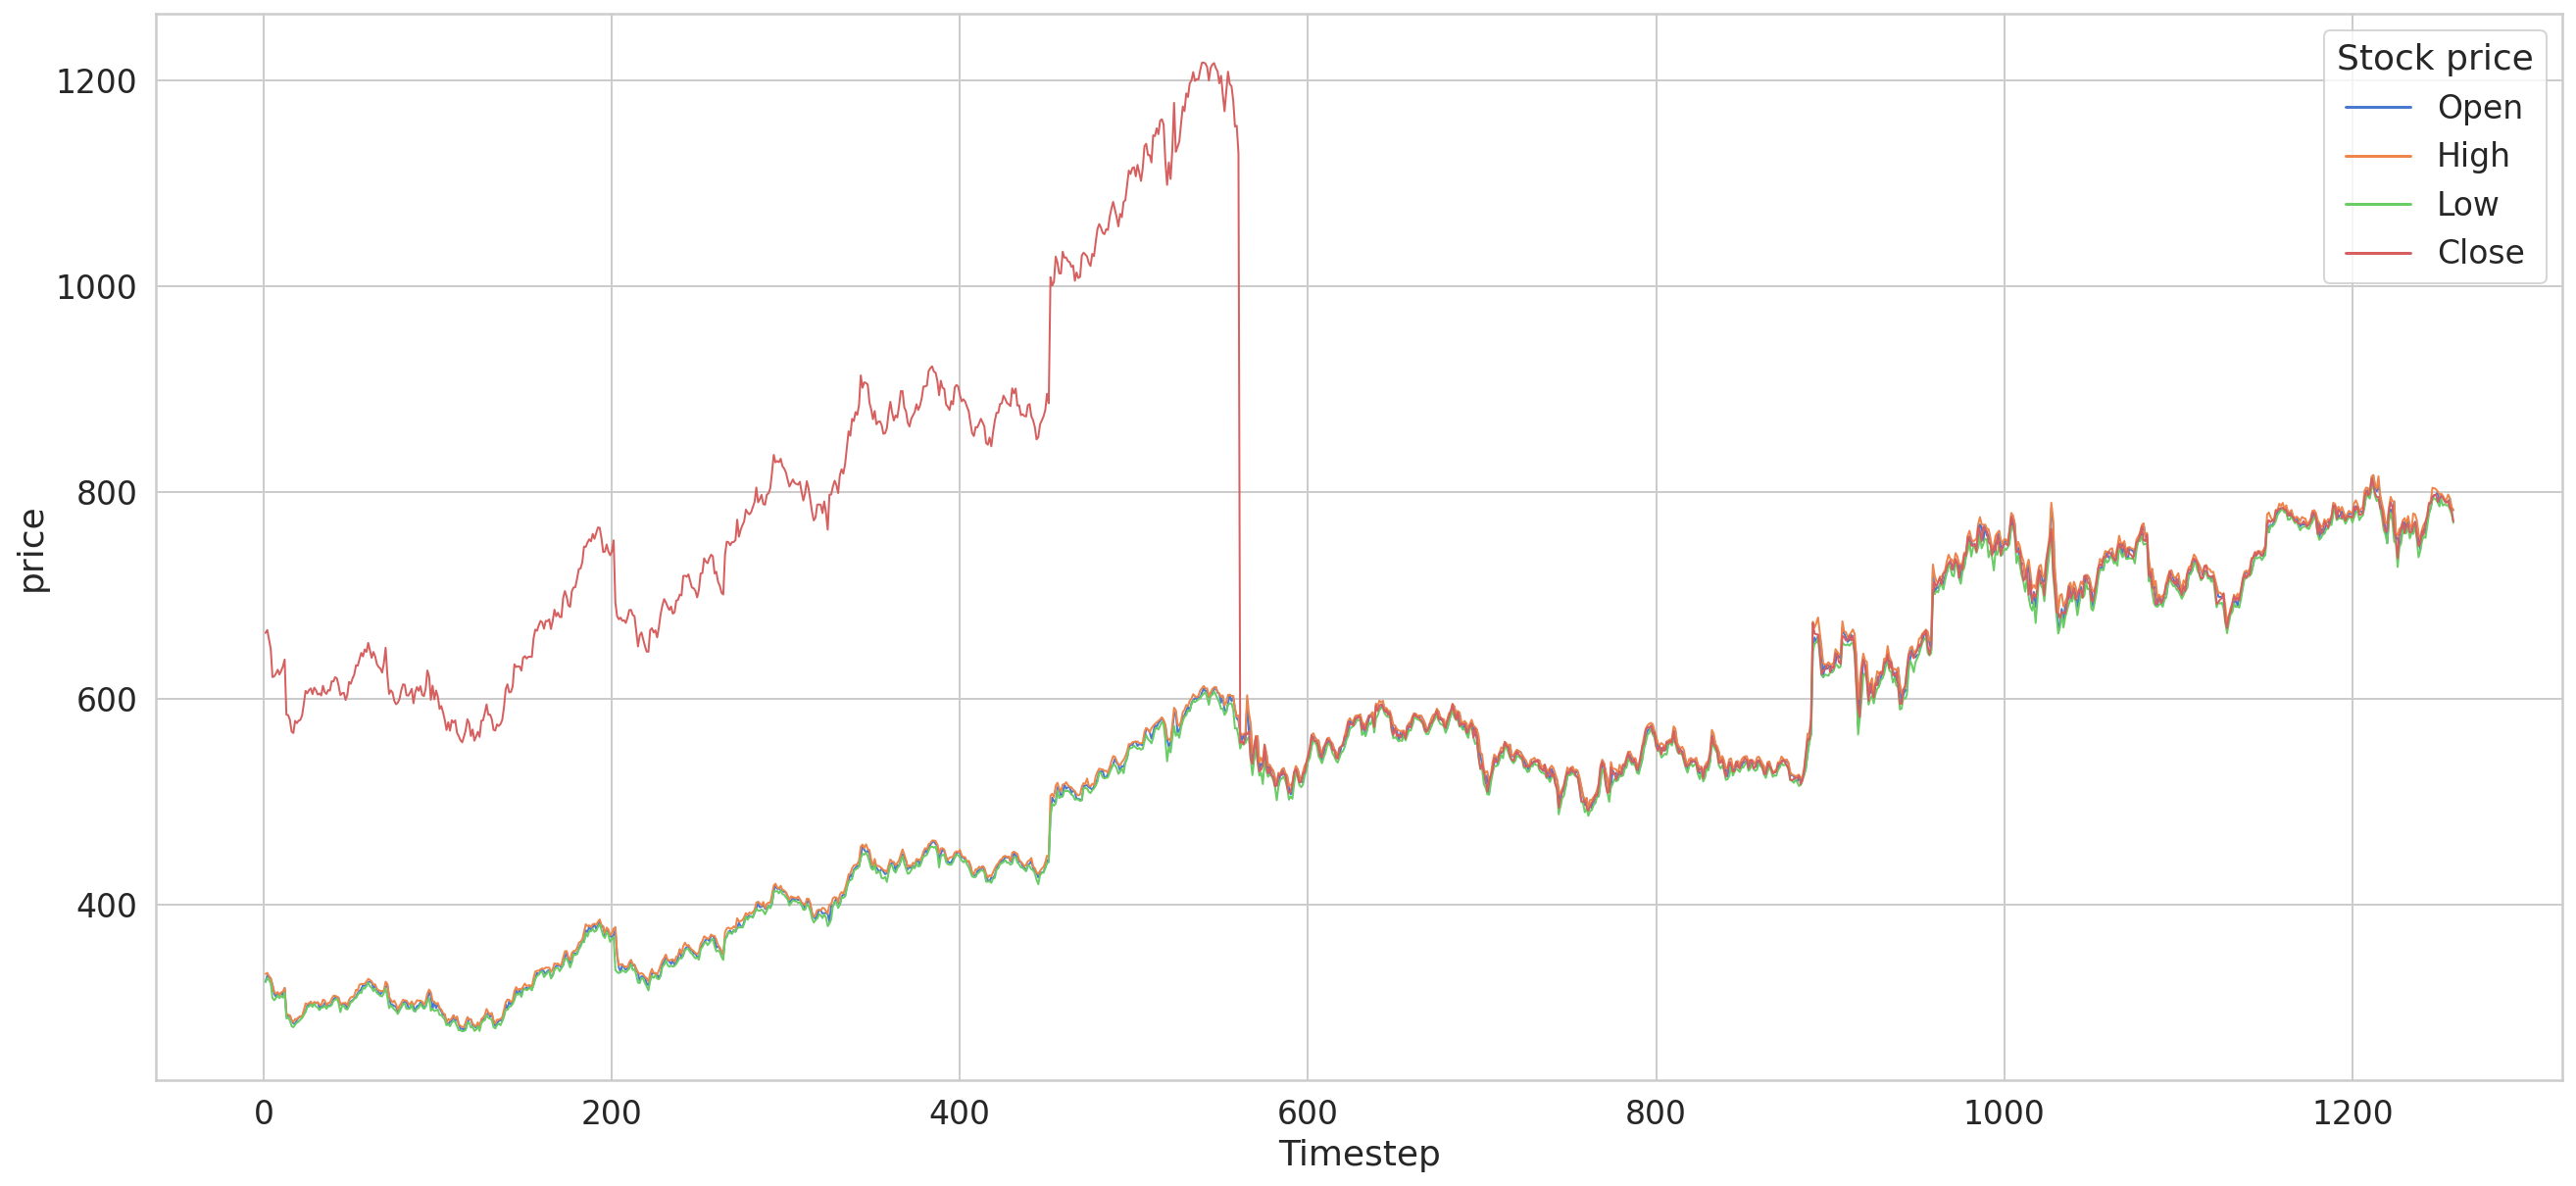

In [10]:
import seaborn as sns

ax1 = sns.lineplot(x="Timestep", y="value", hue="Stock price",linewidth=1,data=training_melt_df).set(ylabel='price')
plt.show()

In [11]:
# Divide by 2.002, for split share going from 1000 to 2002
train['Close'] = np.where(train['High'] < train['Close'], train['Close'] / 2.002, train['Close'])

# Replacing Close price if above High or below Low
train['Close'] = np.where(train['High'] < train['Close'], train['High'], train['Close'])
train['Close'] = np.where(train['Low'] > train['Close'], train['Low'], train['Close'])

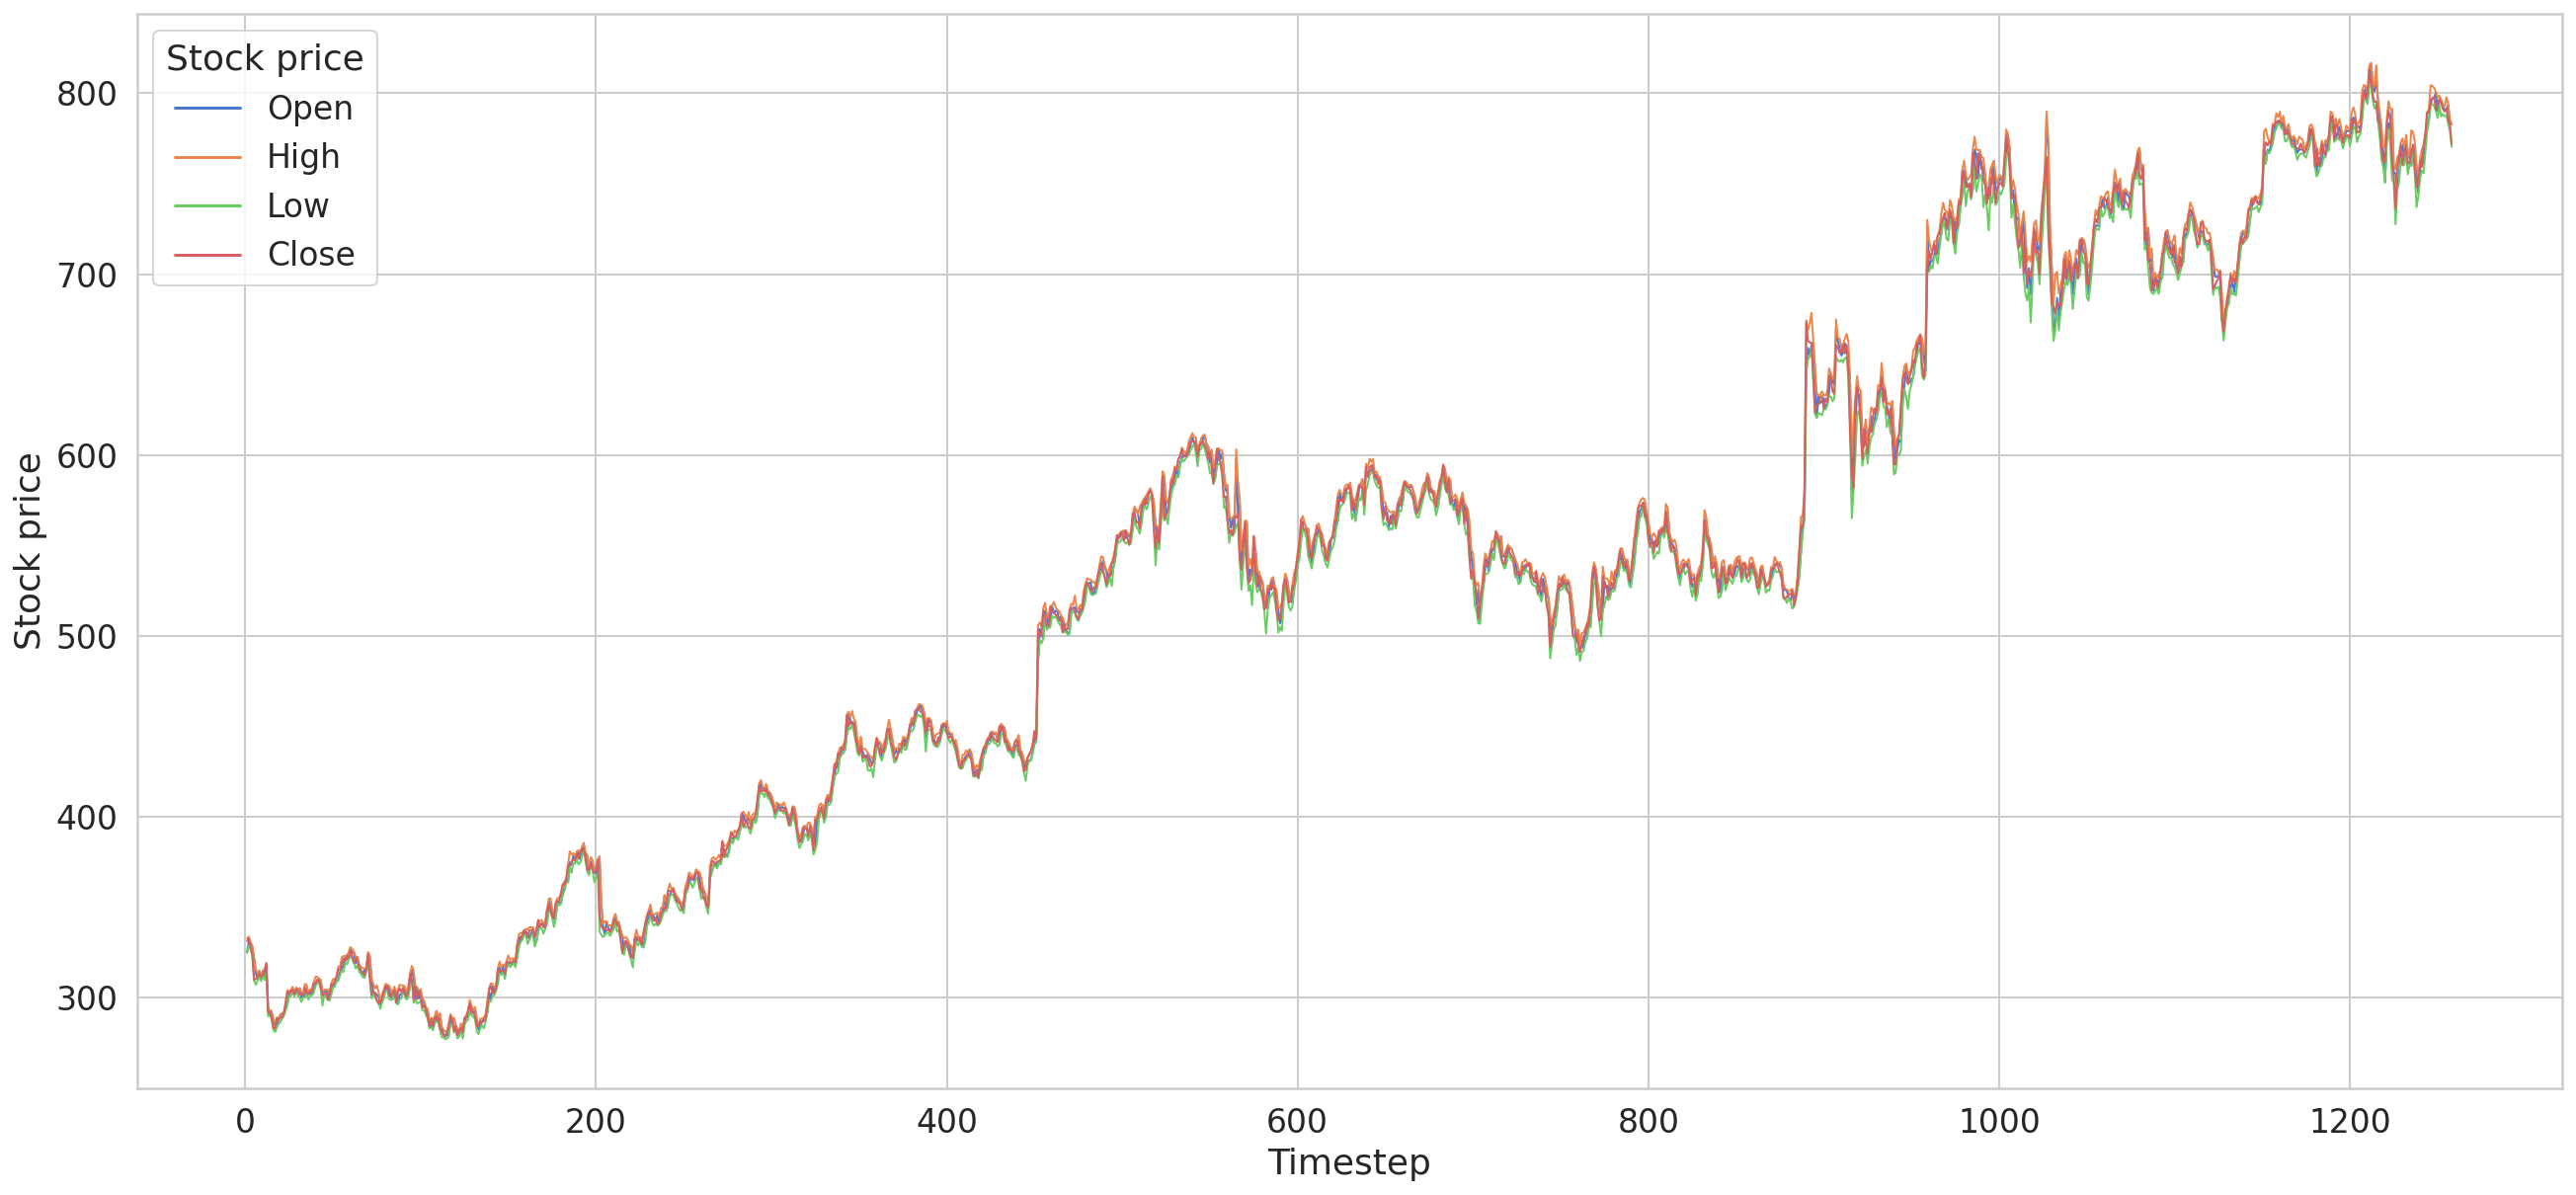

In [12]:
# Melt the data to have all the prices
training_melt_df = pd.melt(train[['Timestep','Open','High','Low','Close']],id_vars= ['Timestep'],value_vars=['Open','High','Low','Close'])
training_melt_df = training_melt_df.rename(columns = {'variable':'Stock price'})

#lineplot with the prices
ax1 = sns.lineplot(x="Timestep", y="value", hue="Stock price",linewidth=1,data=training_melt_df).set(ylabel='Stock price')

In [13]:
train = train.drop(columns=['Timestep','Volume'])

In [14]:
test = test.drop(columns=['Volume'])

In [15]:
# Min max scaling

# Open Price
open_minimum, maximum_open = train['Open'].min(), train['Open'].max()
train['Open'] = (train['Open'] - open_minimum) / (maximum_open - open_minimum)

# Low Price
minimum_low, maximum_low = train['Low'].min(), train['Low'].max()
train['Low'] = (train['Low'] - minimum_low) / (maximum_low - minimum_low)

# High Price
minimum_high, maximum_high = train['High'].min(), train['High'].max()
train['High'] = (train['High'] - minimum_high) / (maximum_high - minimum_high)

# Close Price
minimum_close, maximum_close = train['Close'].min(), train['Close'].max()
train['Close'] = (train['Close'] - minimum_close) / (maximum_close - minimum_close)


In [16]:
# The test data will be rescaled with the same coefficient as the train data, as we are not seeing it yet
test['Open'] = (test['Open'] - open_minimum) / (maximum_open - open_minimum)
test['Low'] = (test['Low'] - minimum_low) / (maximum_low - minimum_low)
test['High'] = (test['High'] - minimum_high) / (maximum_high - minimum_high)
test['Close'] = (test['Close'] - minimum_close) / (maximum_close - minimum_close)


In [17]:
'''
cols = list(train)[0:4]
print(cols)
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

f_transformer = MinMaxScaler()
train.loc[:, cols] = f_transformer.fit_transform(train[cols].to_numpy())
test.loc[:, cols] = f_transformer.transform(test[cols].to_numpy())

open_transformer =MinMaxScaler()
train['Open'] = open_transformer.fit_transform(train[['Open']])
test['Open'] = open_transformer.transform(test[['Open']])
'''

"\ncols = list(train)[0:4]\nprint(cols)\n# Feature Scaling\nfrom sklearn.preprocessing import MinMaxScaler\n\nf_transformer = MinMaxScaler()\ntrain.loc[:, cols] = f_transformer.fit_transform(train[cols].to_numpy())\ntest.loc[:, cols] = f_transformer.transform(test[cols].to_numpy())\n\nopen_transformer =MinMaxScaler()\ntrain['Open'] = open_transformer.fit_transform(train[['Open']])\ntest['Open'] = open_transformer.transform(test[['Open']])\n"

In [18]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [19]:
# Append the train and test data
train_test =  train.append(test)
#train_test = np.append(train, test, axis = None)
train_test

,Open,High,Low,Close
Date,,,,
2012-01-03,0.085814,0.096401,0.090449,0.099101
2012-01-04,0.097012,0.098344,0.098235,0.101773
2012-01-05,0.094334,0.092517,0.094086,0.093140
2012-01-06,0.091562,0.088819,0.088006,0.084759
2012-01-09,0.079842,0.076718,0.061070,0.059085
...,...,...,...,...
2017-01-25,1.024072,1.035651,1.037733,1.042198
2017-01-26,1.039307,1.039815,1.041427,1.035614
2017-01-27,1.033540,1.047192,1.028982,1.019079


In [20]:

data = train_test[['Open','High','Low','Close']].values
window_size = 40
# Empty list were we will store the result
data_window = []

n = len(data)

# create all possible sequences of length seq_len
for index in range(0, n - window_size): 
    data_window.append(data[index:(index + window_size + 1),:])

data_window  = np.array(data_window)

x_full = data_window[:,:-1,:]
y_full = data_window[:,-1,:]


In [21]:
# Splitting into train, validation and test data
x_train = x_full[:(len(train) - 40 - len(test)),:,:]
y_train = y_full[:(len(train) - 40 - len(test)),:]

x_val = x_full[(len(train) - 40 - len(test)):(len(test) - 40),:,:]
y_val = y_full[(len(train) - 40 - len(test)):(len(test) - 40),:]

x_test = x_full[(len(train) - 40):,:,:]
y_test = y_full[(len(train) - 40):,:]

In [22]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(1198, 40, 4) (1198, 4) (20, 40, 4) (20, 4) (20, 40, 4) (20, 4)


In [23]:
X_train, y_train,X_val,Y_val,X_test,y_test = np.array(x_train), np.array(y_train),np.array(x_val), np.array(y_val),np.array(x_test), np.array(y_test)

In [24]:
'''
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train['Open'], time_steps)
X_test, y_test = create_dataset(test, test['Open'], time_steps)

print(X_train.shape, y_train.shape)
'''

"\ntime_steps = 1\n\n# reshape to [samples, time_steps, n_features]\n\nX_train, y_train = create_dataset(train, train['Open'], time_steps)\nX_test, y_test = create_dataset(test, test['Open'], time_steps)\n\nprint(X_train.shape, y_train.shape)\n"

In [25]:
lr = 1e-3
n_outputs = y_train.shape[1]
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=64, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(n_outputs, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
history = model.fit(
    X_train, y_train, 
    epochs=1000, 
    batch_size=32,
    validation_data = (X_val, Y_val),
    shuffle=False
)

Epoch 1/1000
38/38 [==============================] - 1s 21ms/step - loss: 0.0101 - val_loss: 0.0064
Epoch 2/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0015
Epoch 3/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 9.3258e-04
Epoch 4/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 5/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 6.5141e-04
Epoch 6/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 4.8417e-04
Epoch 7/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 8/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 9.7536e-04
Epoch 9/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 4.2762e-04
Epoch 10/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.00

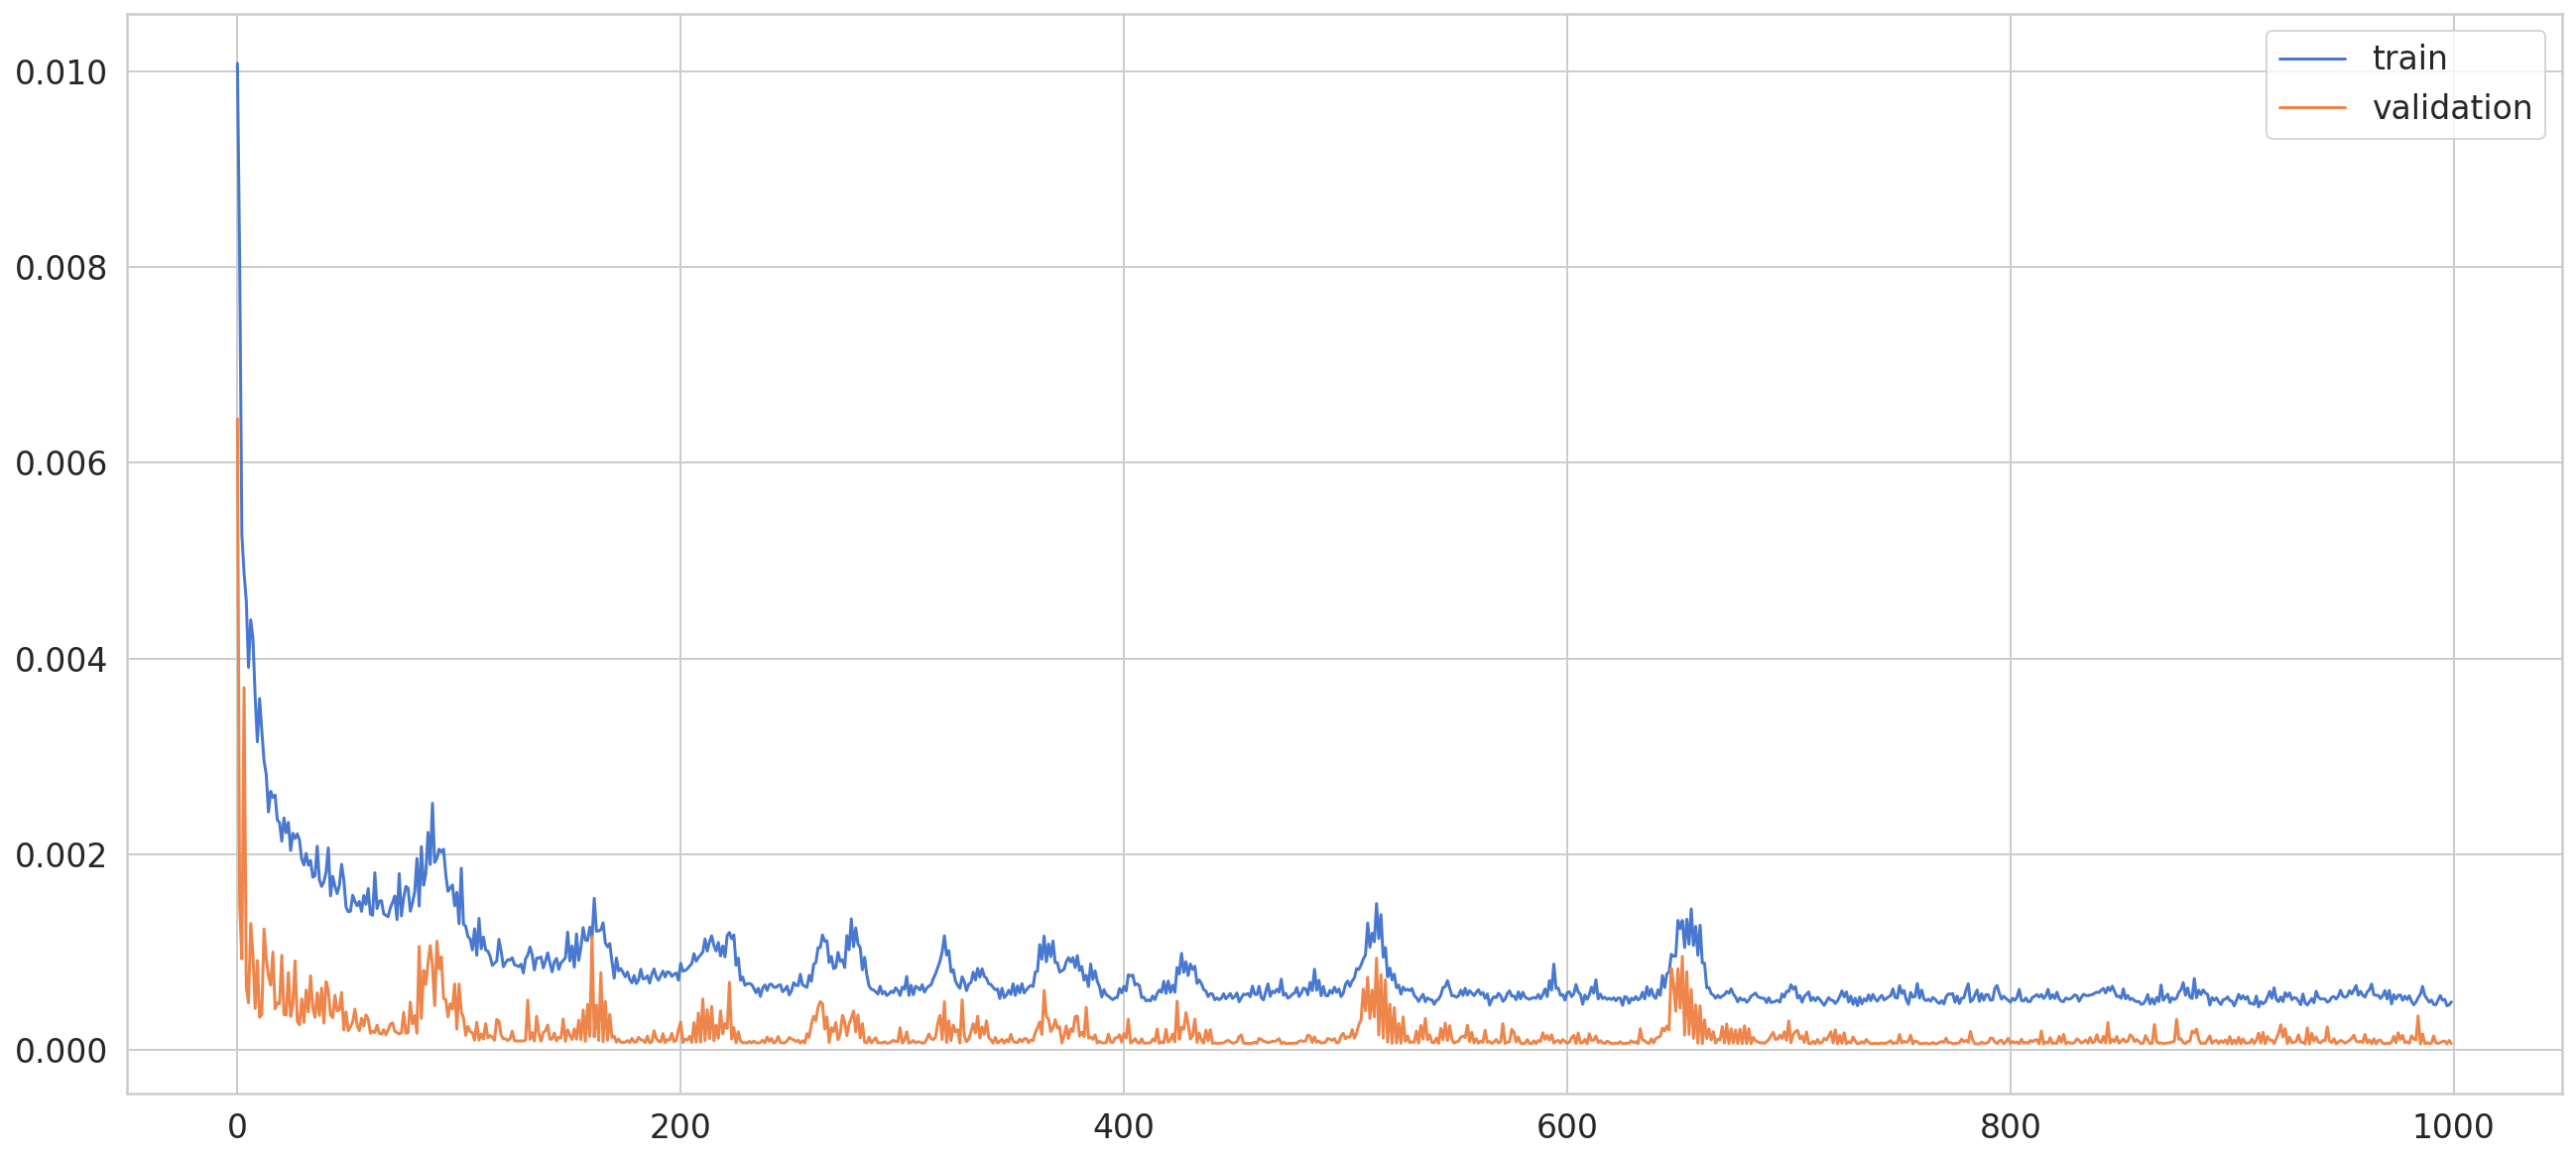

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [28]:
y_pred = model.predict(X_test)

In [29]:
test_original = test_data.iloc[0:len(test_data)]

In [30]:
predicted_df = pd.DataFrame(y_pred,columns=['Predicted_Open','Predicted_High','Predicted_Low','Predicted_Close'])


In [31]:
# Get the original prices in the predicted dataset
predicted_df['Predicted_Open'] = (predicted_df['Predicted_Open'] * (maximum_open-open_minimum)) + open_minimum
predicted_df['Predicted_High'] = (predicted_df['Predicted_High'] * (maximum_high-minimum_high)) + minimum_high
predicted_df['Predicted_Low'] = (predicted_df['Predicted_Low'] * (maximum_low-minimum_low)) + minimum_low
predicted_df['Predicted_Close'] = (predicted_df['Predicted_Close'] * (maximum_close-minimum_close)) + minimum_close

In [32]:
predicted_df['Timestep'] = np.arange(start = 1, stop = len(predicted_df) + 1 , step = 1 )
predicted_df['Open'] = test_original['Open'].astype(float)
test_original = test_original.set_index(predicted_df.index)
predicted_df['Open'] = test_original.iloc[:,0].values

In [33]:
predicted_df

,Predicted_Open,Predicted_High,Predicted_Low,Predicted_Close,Timestep,Open
0,775.475952,781.653931,769.244263,775.070435,1,778.81
1,790.295410,796.484619,784.452271,790.062988,2,788.36
2,790.555298,796.770142,784.618774,790.247314,3,786.08
3,794.169739,800.359619,788.369507,793.898010,4,795.26
4,806.095459,812.333496,800.479614,805.892151,5,806.40
5,806.417358,812.700439,800.664185,806.157104,6,807.86
6,804.626953,810.923950,798.791260,804.354919,7,805.00
7,807.603149,813.916626,801.810303,807.372375,8,807.14
8,804.914490,811.228271,799.049683,804.644226,9,807.48
9,808.464783,814.774780,802.709961,808.234253,10,807.08


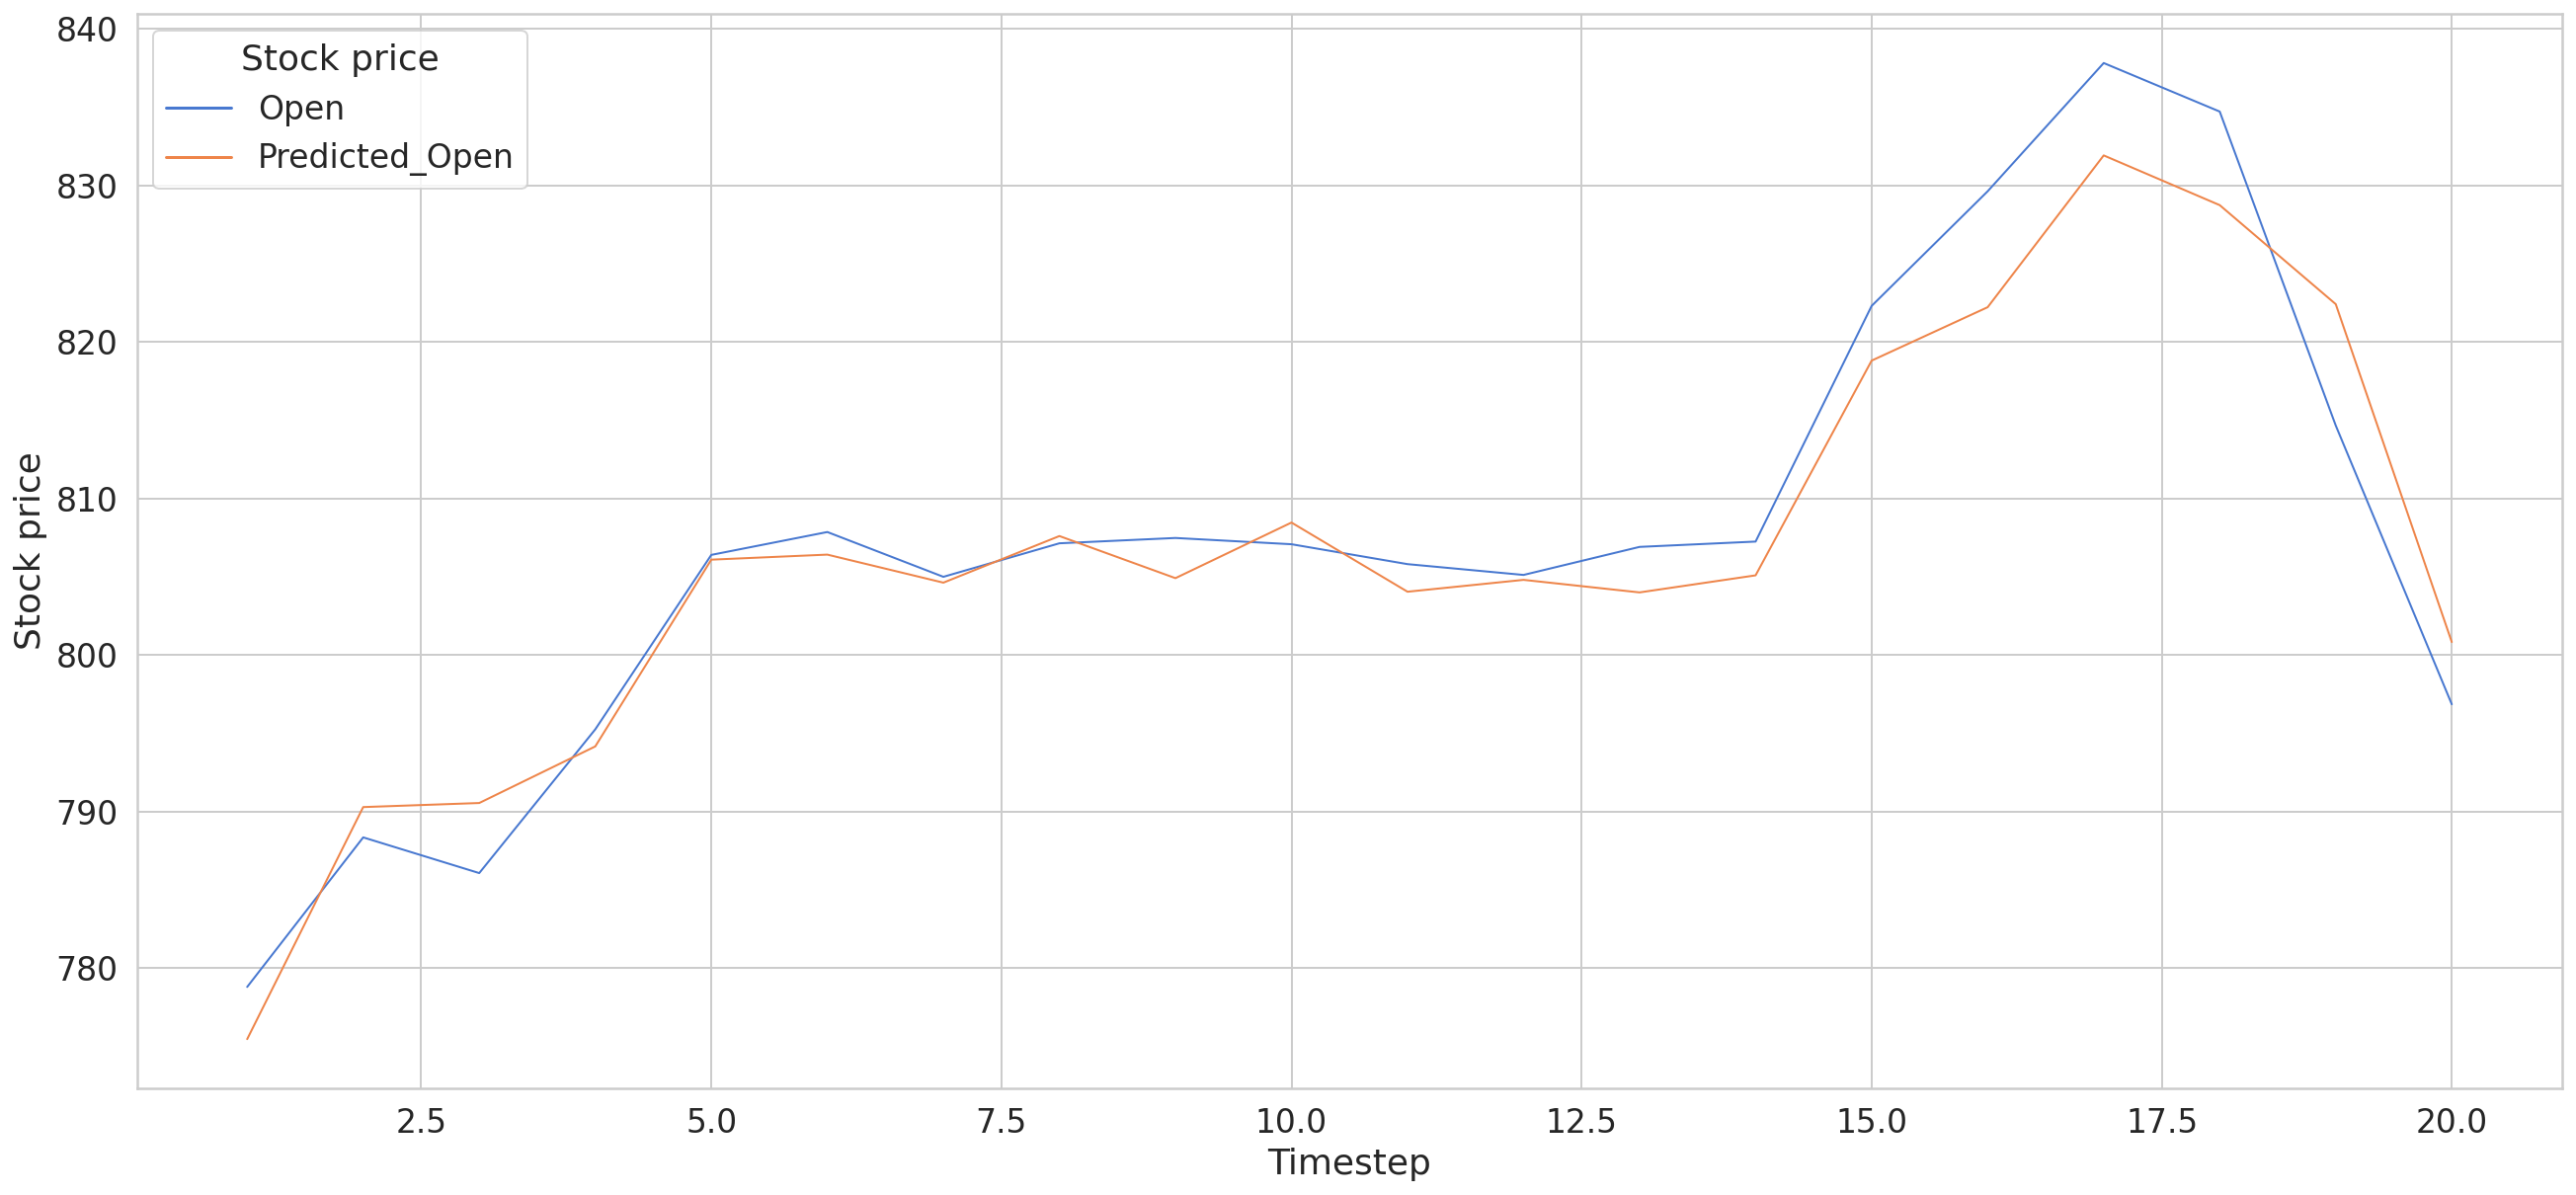

In [34]:
# Melt the data to have all the prices
predicted_df_melt = pd.melt(predicted_df[['Timestep','Open','Predicted_Open']],id_vars= ['Timestep'],value_vars=['Open','Predicted_Open'])
predicted_df_melt = predicted_df_melt.rename(columns = {'variable':'Stock price'})

#lineplot with the prices
ax1 = sns.lineplot(x="Timestep", y="value", hue="Stock price",linewidth=1,data=predicted_df_melt).set(ylabel='Stock price')

In [35]:
# Calculation of the root mean squared error
def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

In [36]:
rootMeanSquareError = rmse(test_original['Open'],predicted_df['Predicted_Open'])
print('RMSE = {}'.format(rootMeanSquareError))

RMSE = 3.7201157203205493
